# 4.11.05 Decision trees and random forest

### Load data

In [1]:
# import commands
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Load the train features npz file
with np.load("train_features.npz", allow_pickle=False) as tr:
    # Load the arrays
    tr_features=tr["tr_features"]

In [3]:
# Load the train batch npz file
with np.load("train_batch.npz", allow_pickle=False) as tr:
    # Load the arrays
    tr_batch_imgs=tr["tr_batch_imgs"], 
    tr_batch_labels=tr["tr_batch_labels"]

In [4]:
# Load the test features npz file
with np.load("test_features.npz", allow_pickle=False) as te:
    # Load the arrays
    te_features=te["te_features"]

In [5]:
# Load the test batch npz file
with np.load("test_batch.npz", allow_pickle=False) as te:
    # Load the arrays
    te_batch_imgs=te["te_batch_imgs"], 
    te_batch_labels=te["te_batch_labels"]

In [6]:
# Load the validation features npz file
with np.load("valid_features.npz", allow_pickle=False) as vl:
    # Load the arrays
    vl_features=vl["vl_features"]

In [7]:
# Load the validation batch npz file
with np.load("valid_batch.npz", allow_pickle=False) as vl:
    # Load the arrays
    vl_batch_imgs=vl["vl_batch_imgs"], 
    vl_batch_labels=vl["vl_batch_labels"]

## Task 1: Decision tree
What accuracy can you achieve using a decision trees with a depth of 3? Plot the corresponding decision tree with plot_tree()

In [8]:
from sklearn.tree import DecisionTreeClassifier

# Create decision tree
dt = DecisionTreeClassifier(criterion="gini", max_depth=3, random_state=0)

/Users/tabea-retina/opt/anaconda3/envs/adsml/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [9]:
# Fit decision tree
dt.fit(tr_features, tr_batch_labels)

# Get scores
print("Train accuracy: {:.1f}%".format(100 * dt.score(tr_features, tr_batch_labels)))
print("Test accuracy: {:.1f}%".format(100 * dt.score(te_features, te_batch_labels)))

Train accuracy: 77.5%
Test accuracy: 66.0%


In [10]:
# Proportion of features in each class
pd.value_counts(tr_batch_labels, normalize=True)

0.0    0.235714
1.0    0.228571
2.0    0.182143
4.0    0.150000
3.0    0.114286
5.0    0.089286
dtype: float64

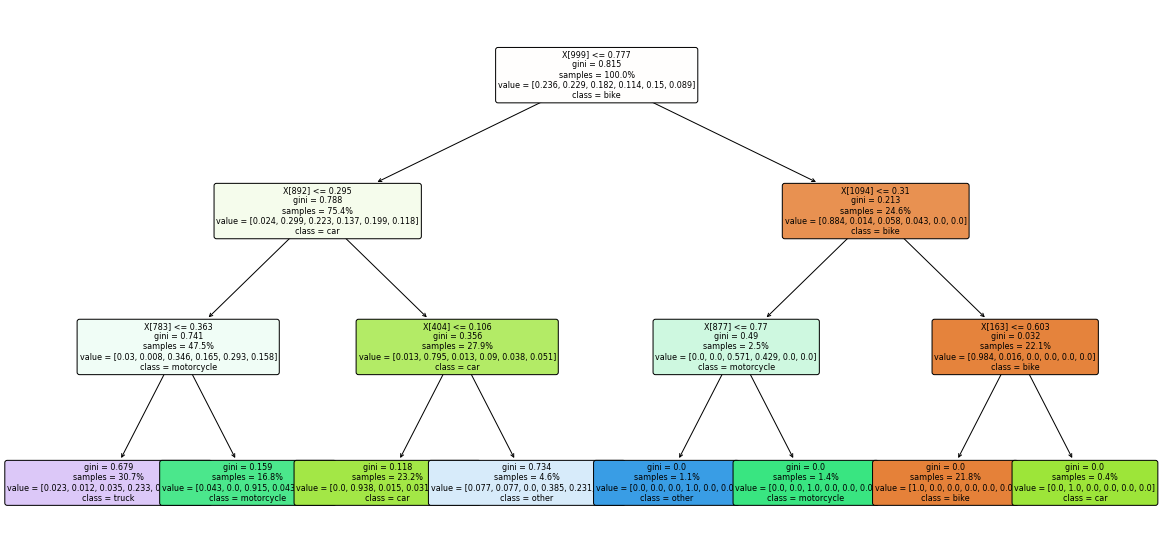

In [11]:
from sklearn.tree import plot_tree
%matplotlib inline
import matplotlib.pyplot as plt


plt.figure(figsize=(20, 10))
plot_tree(
    dt,
    filled=True,
    rounded=True,
    class_names=["bike", "car", "motorcycle", "other", "truck", "van"],
    proportion=True,
    fontsize=8
)
plt.show()


## Task 2: Depth
Tune the depth of your decision tree. Does it improve the accuracy?

In [12]:
# import commands
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [13]:
# Create pipeline
pipe = Pipeline([('scaler', StandardScaler()),
                 ('dec_tree', DecisionTreeClassifier(criterion="gini", random_state=0))])

In [14]:
# Maximum number of levels in tree
max_depth = list(range(1,11))
parameters = dict(dec_tree__max_depth=max_depth)

In [15]:
# # Search of parameters, using 5 fold cross validation
dt_GS = GridSearchCV(pipe, parameters, cv=5, return_train_score=True)

In [16]:
# merge test and validation dataset for hyperparameter tunning
X = np.append(tr_features, vl_features, axis=0)
y = np.append(tr_batch_labels, vl_batch_labels, axis=0)
print(X.shape, y.shape)

(419, 1280) (419,)


In [17]:
# Fit estimator
dt_GS.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('dec_tree',
                                        DecisionTreeClassifier(random_state=0))]),
             param_grid={'dec_tree__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                 10]},
             return_train_score=True)

In [18]:
# Get the result keys
dt_GS.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_dec_tree__max_depth', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

In [19]:
# Visualize the results in a DataFrame
dt_results = pd.DataFrame(dt_GS.cv_results_)

# Print a few interesting columns
cols = [
    "mean_test_score",
    "std_test_score",
    "mean_train_score",
    "std_train_score",
    "param_dec_tree__max_depth",
]
dt_results[cols].sort_values("mean_test_score", ascending=False)

,mean_test_score,std_test_score,mean_train_score,std_train_score,param_dec_tree__max_depth
4,0.730264,0.025015,0.914670,0.012078,5
8,0.706426,0.018065,0.997612,0.003481,9
6,0.701721,0.011849,0.981494,0.010582,7
5,0.701692,0.023503,0.954049,0.011444,6
3,0.701606,0.016311,0.832333,0.015093,4
9,0.699283,0.019012,0.999403,0.001194,10
2,0.694464,0.015241,0.761931,0.005853,3
7,0.675473,0.014626,0.992836,0.006147,8
1,0.579948,0.017475,0.609781,0.003351,2
0,0.439099,0.014506,0.442122,0.003620,1


In [20]:
print('Best max_depth:', dt_GS.best_estimator_.get_params()['dec_tree__max_depth'])

Best max_depth: 5


In [21]:
print("Accuracy for our test dataset is : {:.2f}%".format(100 * dt_GS.score(te_features, te_batch_labels)))

Accuracy for our test dataset is : 80.00%


_Observation: Tuning the depth of the decision tree improves the accurancies._

## Task 3: PCA (optional) 
Do you get better results with your decision tree if you reduce the number of dimensions with PCA first?

In [22]:
from sklearn import decomposition

In [23]:
# Create pipeline
pipe2 = Pipeline([('scaler', StandardScaler()),
                  ('pca', decomposition.PCA()),
                 ('dec_tree', DecisionTreeClassifier(criterion="gini", random_state=0))])

In [24]:
# create PCA parameters
n_components = list(range(1,11))
parameters2 = dict(pca__n_components=n_components, dec_tree__max_depth=max_depth)

In [25]:
# Search of parameters, using 5 fold cross validation
dt_GS2 = GridSearchCV(pipe2, parameters2, cv=5, return_train_score=True)

# Fit estimator
dt_GS2.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('dec_tree',
                                        DecisionTreeClassifier(random_state=0))]),
             param_grid={'dec_tree__max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]},
             return_train_score=True)

In [26]:
print('Best max_depth:', dt_GS2.best_estimator_.get_params()['dec_tree__max_depth'])
print('Best number of components:', dt_GS2.best_estimator_.get_params()['pca__n_components'])

Best max_depth: 5
Best number of components: 3


In [27]:
print("Accuracy for our test dataset is : {:.2f}%".format(100 * dt_GS2.score(te_features, te_batch_labels)))

Accuracy for our test dataset is : 90.00%


_Observation: By reducing the number of dimensions the the accurancies improve._

## Task 4: Random forest
Try a random forest model and tune the number of trees and their depth. Does increasing the number of trees help? Is there an optimal depth and how does it compare to your decision tree above?

In [28]:
# import command
from sklearn.ensemble import RandomForestClassifier

In [29]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]

# Maximum number of levels in tree
max_depth = list(range(2,6))

# Create the grid
grid = {'n_estimators': n_estimators,
               'max_depth': max_depth}

print(grid)

{'n_estimators': [200, 400, 600, 800, 1000], 'max_depth': [2, 3, 4, 5]}


In [46]:
# Search of parameters, using 5 fold cross validation
rfc_GS = GridSearchCV(RandomForestClassifier(random_state=0), grid, return_train_score=True,  verbose=1)

# Fit estimator
rfc_GS.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


GridSearchCV(estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [2, 3, 4, 5],
                         'n_estimators': [200, 400, 600, 800, 1000]},
             return_train_score=True, verbose=1)

In [31]:
rfc_GS.best_params_

{'max_depth': 5, 'n_estimators': 1000}

In [32]:
print("Accuracy for our test dataset is : {:.2f}%".format(100 * rfc_GS.score(te_features, te_batch_labels)))

Accuracy for our test dataset is : 96.00%


_Observation: Compared to the decision tree from above, accurencies are clearly higher with a random forest classifier._

## Task 5: Top 5 important features
The random forest estimator provides a ranking of the features according to their importance in the classification task via the feature_importances_ attribute. Find the the top 5 important features and visualize their importance scores.

In [53]:
# Create random forest classifier
rf = RandomForestClassifier(n_estimators=1000, max_depth=5, random_state=0)

# Fit estimator
rf.fit(X, y)

RandomForestClassifier(max_depth=5, n_estimators=1000, random_state=0)

In [54]:
# indices of the top 5 important features
index = rf.feature_importances_.argsort()[-5:]
index

array([ 892,  801,  466,  999, 1239])

In [55]:
# importance score of the top 5 important features
values = rf.feature_importances_[index]
values

array([0.01179247, 0.0120874 , 0.01362854, 0.01460591, 0.01547738])

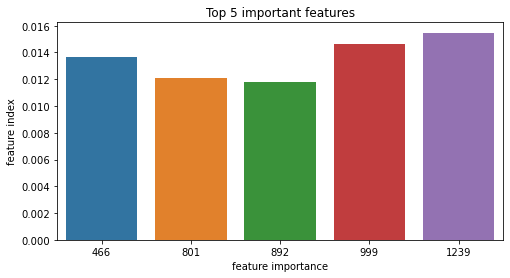

In [56]:
import seaborn as sns

#Define size of bar plot
plt.figure(figsize=(8,4))

#Plot Searborn bar chart
sns.barplot(x=index, y=values)

#Add chart labels
plt.title('Top 5 important features')
plt.xlabel('feature importance')
plt.ylabel('feature index')

plt.show()

## Task 6: Comparing features
Are these top features similar to the ones you found based on the coefficients in the logistic regression task, and also during the data exploration in the last question of Task 1?

_No, there are not similar._